In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
sys.path.append('src/')
# scripts
from clean_helpers import *
#libraries
import pandas as pd
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.pipeline import Pipeline
# modeling
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBRFClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier

/Users/sam/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
def preprocess(df):
    df.Age = df.Age.fillna(value=df.Age.mean())
    # create new class U for unkown embarking locations
    df.Embarked = df.Embarked.fillna(value='U')
    df.Embarked = df.Embarked.replace('C','Cherbourg').replace('Q','Queenstown').replace('S','Southampton')
    df.Fare = df.Fare.fillna(value=df.Fare.mean())
    df.Age = df.Age.fillna(value=df.Age.mean())
    df.set_index('PassengerId', inplace=True, drop=True)
    df.drop('Cabin', axis=1, inplace=True)
    df.drop('Ticket', axis=1, inplace=True)
    df.drop('Name', axis=1, inplace=True)
    return df

def get_train_X_y(path_to_data_folder):
    df = pd.read_csv(f'{path_to_data_folder}/train.csv')
    df = preprocess(df)
    X = df.drop('Survived',axis=1)
    y = df.Survived
    return X, y

def get_test(path_to_data_folder):
    df = pd.read_csv(f'{path_to_data_folder}/test.csv')
    return preprocess(df)

In [4]:
X, y = get_train_X_y('data/')
X

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
PassengerId,,,,,,,
1,3,male,22.000000,1,0,7.2500,Southampton
2,1,female,38.000000,1,0,71.2833,Cherbourg
3,3,female,26.000000,0,0,7.9250,Southampton
4,1,female,35.000000,1,0,53.1000,Southampton
5,3,male,35.000000,0,0,8.0500,Southampton
...,...,...,...,...,...,...,...
887,2,male,27.000000,0,0,13.0000,Southampton
888,1,female,19.000000,0,0,30.0000,Southampton
889,3,female,29.699118,1,2,23.4500,Southampton


## Custom Transform Classes

In [5]:
class CustomScaler:
    '''
    This is a custom StandardScaler implementation for Pipeline.
    '''
    def __init__(self, continuous_cols):
        self.continuous_cols = continuous_cols
        self.ss = StandardScaler()
        print(f'creating StandardScaler object for {continuous_cols} in X') 
        pass
        
    def fit(self, X, y):
        self.X = X
        self.y = y
        self.continuous = self.X[self.continuous_cols]
        self.ss.fit(self.continuous)
        pass
        
    def transform(self, X, y):
        self.scaled_data = self.ss.transform(self.continuous)
        self.scaled_data = pd.DataFrame(self.scaled_data, columns=self.continuous_cols)
        self.scaled_data.index = self.X.index
        self.X.drop(self.continuous_cols, axis=1, inplace=True)
        return pd.concat([self.X, self.scaled_data],axis=1, )

ss = CustomScaler(['Age','Fare'])
ss.fit(X, y)
X = ss.transform(X, y)
X.isna().sum()

creating StandardScaler object for ['Age', 'Fare'] in X


Pclass      0
Sex         0
SibSp       0
Parch       0
Embarked    0
Age         0
Fare        0
dtype: int64

In [6]:
class CustomEncoder:
    '''
    This is a custom OneHotEncoder implementation for Pipeline
    '''
    

    def __init__(self, categorical_cols=None):
        self.categories = categorical_cols
        if categorical_cols:
            print(f'creating a OneHotEncoder object for {categorical_cols}')
        pass
    
    def fit(self, X, y):
        pass
        
        
    def transform(self, X, y):
        for col in self.categories:
            ohe = OneHotEncoder()
            feature = np.array(X[col]).reshape(-1,1)
            ohe.fit(feature)
            encoded = pd.DataFrame(ohe.transform(feature).toarray())
            encoded.index = X.index
            X = pd.concat([X,encoded],axis=1)
            for name in encoded.columns:
                X.rename(columns={name:f'{col}: {name}'},inplace=True)
            X.drop(col,inplace=True,axis=1)
        return X
    
cols = ['Pclass','Sex','Parch','SibSp','Embarked']    
ohe = CustomEncoder(cols)
ohe.fit(X, y)
X = ohe.transform(X, y)
X.head()


creating a OneHotEncoder object for ['Pclass', 'Sex', 'Parch', 'SibSp', 'Embarked']


,Age,Fare,Pclass: 0,Pclass: 1,Pclass: 2,Sex: 0,Sex: 1,Parch: 0,Parch: 1,Parch: 2,...,SibSp: 1,SibSp: 2,SibSp: 3,SibSp: 4,SibSp: 5,SibSp: 6,Embarked: 0,Embarked: 1,Embarked: 2,Embarked: 3
PassengerId,,,,,,,,,,,,,,,,,,,,,
1,-0.592481,-0.502445,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.638789,0.786845,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,-0.284663,-0.488854,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.407926,0.420730,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
5,0.407926,-0.486337,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [7]:
X.columns

Index(['Age', 'Fare', 'Pclass: 0', 'Pclass: 1', 'Pclass: 2', 'Sex: 0',
       'Sex: 1', 'Parch: 0', 'Parch: 1', 'Parch: 2', 'Parch: 3', 'Parch: 4',
       'Parch: 5', 'Parch: 6', 'SibSp: 0', 'SibSp: 1', 'SibSp: 2', 'SibSp: 3',
       'SibSp: 4', 'SibSp: 5', 'SibSp: 6', 'Embarked: 0', 'Embarked: 1',
       'Embarked: 2', 'Embarked: 3'],
      dtype='object')

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

In [9]:
logit = LogisticRegression(random_state=42)
logit.fit(X_train, y_train)
np.mean(cross_val_score(logit, X_test, y_test))

0.7947589098532494

In [10]:
# *** #
rf = RandomForestClassifier(criterion='entropy', min_samples_split=4, random_state=42)
rf.fit(X_train, y_train)
np.mean(cross_val_score(rf, X_test, y_test))

0.8135569531795946

In [11]:
xgb = XGBRFClassifier(max_depth=4,random_state=42)
xgb.fit(X_train, y_train)
np.mean(cross_val_score(xgb, X_test, y_test))

0.8059399021663174

In [12]:
models = [('log',logit),('rfc',rf),('xgbrfc',xgb)]
voter_all = VotingClassifier(estimators=models, voting='soft')
voter_all.fit(X_train,y_train)
np.mean(cross_val_score(voter_all,X_test,y_test))

0.7910552061495457

In [13]:
voter_log_rfc = VotingClassifier(estimators=models[0:2],voting='soft')
voter_log_rfc.fit(X_train,y_train)
np.mean(cross_val_score(voter_log_rfc,X_test,y_test))

0.8208944793850452

## Test Predictions

In [14]:
X_TEST = get_test('data/')

In [15]:
test_scaler = CustomScaler(['Age','Fare'])
test_scaler.fit(X_TEST, y)
X_TEST = test_scaler.transform(X_TEST, y)

cols = ['Pclass','Sex','Parch','SibSp','Embarked'] 
test_encoder = CustomEncoder(cols)
test_encoder.fit(X_TEST, y)
X_TEST = test_encoder.transform(X_TEST, y)

creating StandardScaler object for ['Age', 'Fare'] in X
creating a OneHotEncoder object for ['Pclass', 'Sex', 'Parch', 'SibSp', 'Embarked']


In [30]:
def model_agree_rate(model1, model2, X):
    agree_rate = (model1.predict(X) == model2.predict(X)).sum()/len(X)
    print(f'models agree on roughly {str(np.round(agree_rate,2))[-2:]}% of predictions')
    return agree_rate

model_agree_rate(rf, voter_log_rfc, X_TEST)

models agree on roughly 91% of predictions


0.9090909090909091

In [37]:
model_agree_rate(rf, voter_log_rfc, X_TEST)

models agree on roughly 91% of predictions


0.9090909090909091

In [20]:
voter_log_rfc.predict(X_TEST)

array([0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0,
       1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1,
       1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1,
       0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1,
       0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0,
       1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1,
       0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,

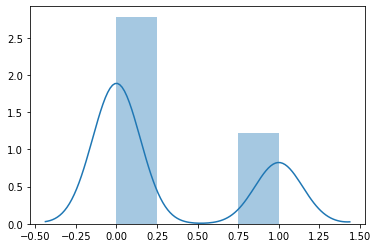

In [21]:
sns.distplot(rf.predict(X_TEST))

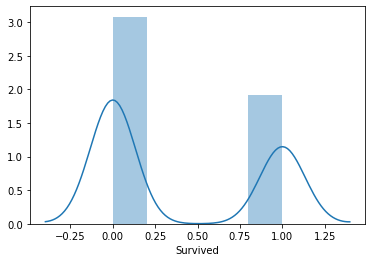

In [22]:
sns.distplot(y)